In [1]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np
from qiskit.synthesis import SuzukiTrotter
from qiskit.quantum_info import Statevector
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.converters import circuit_to_dag
from qiskit import transpile

from cutter_search import *
from resource_analysis import PhysicalParameters


def get_hamiltonian(L, J, h, alpha=0):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, L - 1)]
    Z_tuples = [("Z", [i], -h * np.sin(alpha)) for i in range(0, L)]
    X_tuples = [("X", [i], -h * np.cos(alpha)) for i in range(0, L)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()


Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: 15
             Gate count: 21
    Nonlocal gate count: 8
         Gate breakdown: RZ: 10, CX: 8, RY: 2, RX: 1


SparsePauliOp(['IZZ', 'ZZI', 'IIZ', 'IZI', 'ZII', 'IIX', 'IXI', 'XII'],
              coeffs=[-0.2       +0.j, -0.2       +0.j, -0.38268343+0.j, -0.38268343+0.j,
 -0.38268343+0.j, -0.92387953+0.j, -0.92387953+0.j, -0.92387953+0.j])


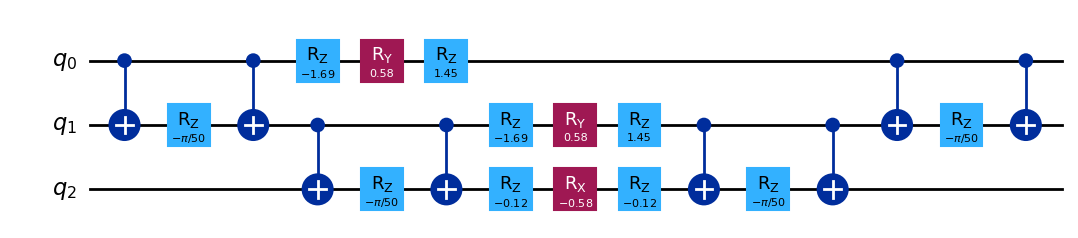

In [2]:
second_order_formula = SuzukiTrotter()

L = 3
H = get_hamiltonian(L=L, J=0.2, h=1.0, alpha=np.pi / 8)
final_time = np.pi
num_timesteps = 10
dt = final_time / num_timesteps
initial_state = Statevector.from_label("000")

trotter_step_second_order = PauliEvolutionGate(H, dt, synthesis=second_order_formula)
circuit = QuantumCircuit(H.num_qubits)
for i in range(1):
    circuit.append(trotter_step_second_order, range(H.num_qubits))
# circuit = circuit.decompose(reps=1)
target_basis = ['rx', 'ry', 'rz', 'h', 'cx']
circuit = transpile(circuit,
                       basis_gates=target_basis, 
                       optimization_level=1) 

# Let us print some stats
print(
    f"""
Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

"""
)
print(H)

circuit.draw("mpl")

In [3]:
# DAG = circuit_to_dag(circuit)
# DAG.draw(scale=0.7)

In [4]:
# import qiskit.qasm2
# export_circ = qiskit.qasm2.dumps(circuit)
# from cirq.contrib.qasm_import import circuit_from_qasm
# import_circ = circuit_from_qasm(export_circ)

In [5]:
# PhysicalParameters.make_beverland_et_al(circuit)

In [6]:
# from cutter import find_cuts_cutqc
# find_cuts_cutqc(circuit,    
#     max_subcircuit_width=np.ceil(circuit.num_qubits / 4 * 3),
#     max_cuts=10,
#     num_subcircuits=[2,3],
#     max_subcircuit_cuts=10,
#     subcircuit_size_imbalance=2,
#     verbose=True,)

In [7]:
# stripped_circ = circuit_stripping(circuit=circuit)
# n_vertices, gedges, wedges, node_name_ids, id_node_names = read_circ(circuit=stripped_circ)

In [8]:
# a = circuit_to_dag(circuit)
# for i in a.nodes_on_wire(wire=circuit_to_dag(circuit).qubits[0], only_ops=True):
#     print(i.qargs)
# print('--------')
# a.remove_op_node(list(circuit_to_dag(circuit).nodes_on_wire(wire=circuit_to_dag(circuit).qubits[0], only_ops=True))[0])
# for i in a.nodes_on_wire(wire=circuit_to_dag(circuit).qubits[0], only_ops=True):
#     print(i.qargs)
# print('---------')
# a.apply_operation_front(op, qargs=[q1])
# a.apply_operation_front(op, qargs=[q2])
# for i in a.nodes_on_wire(wire=circuit_to_dag(circuit).qubits[0], only_ops=True):
#     print(i.qargs)

In [9]:
find_cuts(circuit,    
    max_subcircuit_width=np.ceil(circuit.num_qubits / 4 * 3),
    max_cuts=10,
    num_subcircuits=[2,3],
    max_subcircuit_cuts=10,
    subcircuit_size_imbalance=2,
    verbose=True)

Restricted license - for non-production use only - expires 2025-11-24


[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
--------------------
Cutter result:
2 subcircuits, 3 cuts
subcircuit 0
init qubits = 2, measure qubits = 1, width = 4, effective = 3, depth = 9, size = 10
Operations needed: {'cx': 4, 'rz': 4, 'ry': 1, 'Target0': 1}
Resource needed: PhysicalParameters(Q=88962.0, logical_time_step=0.00010800000000000001, number_of_T_gates=60.0)
                                  ┌────────────┐┌─────────────┐┌────────────┐»
q_0: ─────■────────────────────■──┤ Rz(-1.691) ├┤ Ry(0.58049) ├┤ Rz(1.4506) ├»
        ┌─┴─┐   ┌───────────┐┌─┴─┐└────────────┘└─────────────┘└────────────┘»
q_1: ───┤ X ├───┤ Rz(-π/50) ├┤ X ├───────────────────────────────────────────»
        └───┘   └───────────┘└───┘                      

{'subcircuits': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x131007c50>,
 'complete_path_map': {Qubit(QuantumRegister(3, 'q'), 0): [{'subcircuit_idx': 0,
    'subcircuit_qubit': Qubit(QuantumRegister(4, 'q'), 0)}],
  Qubit(QuantumRegister(3, 'q'), 1): [{'subcircuit_idx': 0,
    'subcircuit_qubit': Qubit(QuantumRegister(4, 'q'), 1)},
   {'subcircuit_idx': 1,
    'subcircuit_qubit': Qubit(QuantumRegister(2, 'q'), 0)},
   {'subcircuit_idx': 0,
    'subcircuit_qubit': Qubit(QuantumRegister(4, 'q'), 2)}],
  Qubit(QuantumRegister(3, 'q'), 2): [{'subcircuit_idx': 1,
    'subcircuit_qubit': Qubit(QuantumRegister(2, 'q'), 1)},
   {'subcircuit_idx': 0,
    'subcircuit_qubit': Qubit(QuantumRegister(4, 'q'), 3)}]},
 'num_cuts': 3,
 'counter': {0: {'effective': 3,
   'init': 2,
   'meas': 1,
   'Q': 4,
   'depth': 9,
   'size': 10},
  1: {'effective': 0, 'init': 1, 'meas': 2, 'Q': 2, 'depth': 8, 'size': 12}}}